<a href="https://colab.research.google.com/github/jagaldol/chat-foodie/blob/feature%2Ffine-tuning/chatbot/fine-tuning/KoAlpaca_QLoRA_ChatFoodie_Model_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# koalpaca-Polyglot-ko 5.8B QLoRA 학습으로 chat foodie 모델 만들기

* 4bit quantization 방법을 통해 Colab Free (T4 GPU)에서 한국어 언어 모델 KoAlpaca-Polyglot-ko 5.8B 을 QLoRA로 파인튜닝 한다.
* 이 학습을 통해 만들어지는 chat foodie 모델은 음식 추천 챗봇에 쓰인다.

In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 8.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 5.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.4/492.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 데이터셋: chatfoodie v1.0

* Fine-Tuning을 위한 도메인 데이터 다운로드
* chatfoodie v1.0은 음식 추천이나 음식 정보 데이터가 대화형으로 만들어진 데이터 셋이다.

In [ ]:
from datasets import load_dataset

# chat-foodie v1.0 데이터셋 다운
data = load_dataset("jagaldol/chat-foodie")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

* 데이터 셋의 개수와 형식을 볼 수 있다.

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 8218
    })
})

* 데이터를 챗봇에 학습시키기 위한 형식으로 매핑한다.

In [ ]:
data = data.map(
    lambda x: {'text': f"### 질문: {x['instruction']}\n\n### 답변: {x['output']}<|endoftext|>" }
)

Map:   0%|          | 0/8218 [00:00<?, ? examples/s]

## 쪼개진 모델 로드

* 본래 모델은 단일 파일로도 있지만, 작은 파일(약 1GB)로 쪼개서 개별로 로드한 레포를 쓰면 RAM 오류없이 사용할 수 있다.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "beomi/KoAlpaca-Polyglot-5.8B"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0})

Loading checkpoint shards:   0%|          | 0/13 [00:00<?, ?it/s]

## 텍스트 데이터만 tokenize

In [ ]:
data = data.map(lambda samples: tokenizer(samples["text"]), batched=True)

Map:   0%|          | 0/8218 [00:00<?, ? examples/s]

* 훈련 세트의 첫 번째 데이터 출력

In [ ]:
data['train'][0]['text']

'### 질문: 크리스마스 뭐 먹을까?\n\n### 답변: 치킨을 먹는 건 어떨까요? 치킨은 언제나 맛있어요.<|endoftext|>'

* PEFT를 통해 `prepare_model_for_kbit_training`로 Low bit 학습을 준비한다.

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

* 기존 모델 중 학습가능한 파라미터의 수를 출력해주는 함수

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

* LoRA 파라미터 정의

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query_key_value"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 3670016 || all params: 3070156800 || trainable%: 0.11953838970048696


## 학습하기

* 한 batch에 데이터 4개씩 2050 스텝, 총 8200개의 데이터(원본 데이터 중 99.8%, 약 1 epoch)를 학습한다.
* optim 파라미터의 값으로 들어간 paged_adamw_8bit 방식은 train loss를 0으로 만드는 오류가 있어서 주석처리하였다.

In [ ]:
import transformers

# needed for gpt-neo-x tokenizer
tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=data["train"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=1,
        max_steps=2050, ## 초소량만 학습: 50 step만 학습. 약 4분정도 걸립니다.
        learning_rate=1e-4,
        fp16=True,
        logging_steps=10,
        logging_dir="./logs",
        output_dir="outputs",
        # optim="paged_adamw_8bit"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
10,3.180800
20,2.486400
30,2.318400
40,1.875000
50,2.022600
60,1.762800
70,1.700400
80,1.704700
90,1.656400
100,1.618900


TrainOutput(global_step=2050, training_loss=1.496195866654559, metrics={'train_runtime': 4735.3089, 'train_samples_per_second': 1.732, 'train_steps_per_second': 0.433, 'total_flos': 1.643202326396928e+16, 'train_loss': 1.496195866654559, 'epoch': 1.0})

In [ ]:
model.eval()
model.config.use_cache = True  # silence the warnings. Please re-enable for inference!

* 모델이 답변을 잘 생성하는지 생성해보기

In [ ]:
model.generate(**tokenizer("### 질문: 점심 추천해줘", return_tensors='pt', return_token_type_ids=False))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1296: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1494: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


tensor([[    6,     6,     6,  2438,    29,  6231,  3046,   310,  3219,   202,
           202,     6,     6,     6,  4253,    29,  6231,   339,   272, 17080]])

* 모델의 답변을 받아와 토큰은 해독하는 함수

In [ ]:
def gen(x):
    gened = model.generate(
        **tokenizer(
            f"### 질문: {x}\n\n### 답변:",
            return_tensors='pt',
            return_token_type_ids=False
        ),
        max_new_tokens=256,
        early_stopping=True,
        do_sample=True,
        eos_token_id=2,
    )
    print(tokenizer.decode(gened[0]).split('###')[2])

## 몇 가지 질문들로 답변 생성해보기

In [ ]:
gen('매운 음식 추천해줘')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 답변: 매운 음식으로는 김치찌개, 갈비찜, 떡볶이, 김치찌개, 불고기 등이 추천됩니다. 매운 음식은 한국인들이 좋아하는 대표적인 음식 중 하나로, 자신의 매운 입맛에 맞게 선택하여 즐기면 더욱 맛있습니다. 매운 음식을 선호하시는 분들에게는 매운 음식과 매운 소스를 조합하여 즐겨보세요. 또한, 매운 음식은 건강에 오히려 좋다는 사실을 염두에 두고 맛있게 드세요. 매운 음식을 즐겨보면서 매운 음식에 관심을 가져보는 건 어떨까요?




In [ ]:
gen('저녁 추천해줘')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 답변: 삼겹살과 김치를 함께 구워보세요! 삼겹살과 김치의 맛과 풍미가 조화로운 조합입니다. 저녁으로는 고기를 구워 먹는 것이 가장 좋고, 김치의 상큼한 맛과 삼겹살의 기름 맛이 잘 어울립니다. 삼겹살과 김치를 함께 먹어보세요! 맛있는 식사를 즐겨보세요. <|endoftext|>


In [ ]:
gen('20대 여자가 좋아하는 음식이 뭐야?')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 답변: 떡볶이 추천드려요. 떡볶이는 매콤하고 고소한 풍미로 유명한 음식으로, 다양한 떡과 어묵, 소시지 등을 사용하여 조리하여 즐길 수 있습니다. 매콤한 맛과 고소한 향이 특징이며, 다양한 재료와 함께 즐길 수 있는 음식입니다. 떡볶이는 특히 많은 사람들이 좋아하는 음식 중 하나입니다. 다양한 시도와 함께 맛있는 음식을 즐겨보아요. <|endoftext|>


In [ ]:
gen('이탈리아 음식 추천해줘')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 답변: 토마토 파스타를 추천드립니다. 토마토 소스는 이탈리아의 대표적인 파스타로, 면과 토마토 소스와 함께 먹는 음식으로 유명한 소스로, 다양한 맛과 풍미를 즐길 수 있습니다. 신선한 토마토와 다양한 야채로 만들어져 건강에도 좋은 음식입니다. 이탈리아 음식을 즐기고 싶다면 토마토 파스타를 시도해보세요. 맛있는 음식을 맛보는 것은 일상에서 특별한 경험입니다. <|endoftext|>


In [ ]:
gen('배가 아플 때 먹을 음식 추천해줘')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 답변: 배가 아플 때 먹을 음식으로는 매운 음식이 좋을 것 같아요. 고춧가루나 매운 소스를 활용하여 먹으면 속이 아플 수 있는 기운을 풀어줄 수 있습니다. 그 외에도 차가운 음식이나 해장을 하고 싶을 때는 콩나물국, 김치찌개, 두부찌개, 라면 등을 추천드려요. 이러한 음식들은 속을 개운하게 만들어 줄 뿐만 아니라 기운을 내게 해줄 수 있으므로 시도해 보세요. 즐거운 식사시간이 되실 거예요. 이렇게 시도해 보는 음식들은 자신만의 방식으로 소화시킬 수 있거나 개인의 취향에 따라 달라지게 됩니다. 좋은 효과를 얻어서 배가 아픈 일이 없었으면 좋겠어요.




## 모델 저장 & 업로드

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
model.push_to_hub('sm136599/chatfoodie-koalpaca-polyglot-5_8b-2050step-4batch_1epoch')

adapter_model.bin:   0%|          | 0.00/14.7M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sm136599/chatfoodie-koalpaca-polyglot-5_8b-2050step-4batch_1epoch/commit/99e5091fa6078404ba1eae0757f988a0a5f0cc43', commit_message='Upload model', commit_description='', oid='99e5091fa6078404ba1eae0757f988a0a5f0cc43', pr_url=None, pr_revision=None, pr_num=None)

## train loss 그래프 그리기

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1500, 1510, 1520, 1530, 1540, 1550, 1560, 1570, 1580, 1590, 1600, 1610, 1620, 1630, 1640, 1650, 1660, 1670, 1680, 1690, 1700, 1710, 1720, 1730, 1740, 1750, 1760, 1770, 1780, 1790, 1800, 1810, 1820, 1830, 1840, 185

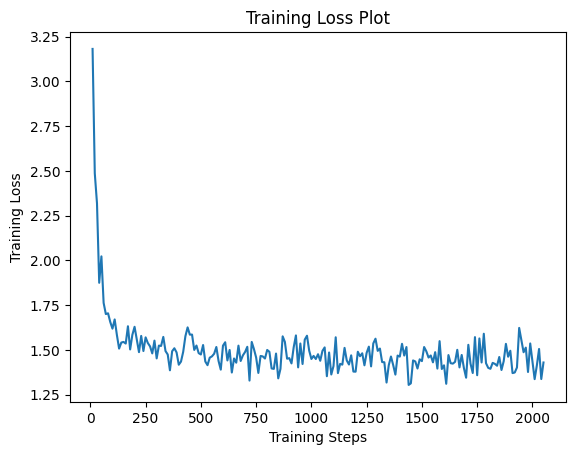

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

training_logs = trainer.state.log_history

loss = []
step = []
for i, log in enumerate(training_logs):
  if (i + 1) % len(training_logs) == 0:
    break
  else:
    loss.append(log['loss'])
    step.append(log['step'])

print(step)
print(loss)
# Plot the loss
plt.plot(step, loss)
plt.xlabel("Training Steps")
plt.ylabel("Training Loss")
plt.title("Training Loss Plot")
plt.show()
